<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/%5B3%EC%A3%BC%EC%B0%A8%5D%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [3주차] 심화과제: Pre-trained모델로 효율적인 NLP 모델 학습하기

In [89]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [90]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR  # 학습률 스케줄러 추가 (Add learning rate scheduler)
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast  # 최신 AMP 모듈 (New AMP module)
import kagglehub
import os

# [MY_CODE]한글 폰트 설정
import matplotlib.font_manager as fm
import warnings
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

## 1. [MY_CODE] 데이터 로드 및 전처리

In [91]:
# Kaggle 데이터를 다운로드 및 경로 설정 (Download Kaggle data and set paths)
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")
dir_path = Path(path)

train_path = dir_path / "train.csv"  # 학습 데이터 경로 (Train data path)
matched_val_path = dir_path / "validation_matched.csv"  # 검증 데이터 경로 (Validation data path)

# 데이터를 pandas 데이터프레임으로 로드 (Load data into pandas DataFrame)
train_df = pd.read_csv(train_path)
matched_val_df = pd.read_csv(matched_val_path)

## 2. [MY_CODE] 필요한 열만 유지

In [92]:
columns_to_keep = ["premise", "hypothesis", "label"]
train_df = train_df[columns_to_keep]
matched_val_df = matched_val_df[columns_to_keep]

## 3. [MY_CODE] 결측치 확인 및 제거

In [93]:
dfs = [train_df, matched_val_df]
data_lst = ["train", "matched_val"]

# 데이터셋의 결측치 통계 출력 (Print missing value statistics)
result = np.array([df.isna().sum().values for df in dfs])
result = pd.DataFrame(result, index=data_lst, columns=columns_to_keep)
print("[LOG] Missing values in datasets (before dropna):")
print(result)

# 결측치가 있는 샘플 제거 (Remove rows with missing values)
for df in dfs:
    df.dropna(subset=["premise", "hypothesis", "label"], inplace=True)

# 각 데이터셋 크기 출력 (Print dataset sizes after cleaning)
for df_name, df in zip(data_lst, dfs):
    print(f"[LOG] Dataset size after dropna in {df_name}: {len(df)}")


[LOG] Missing values in datasets (before dropna):
             premise  hypothesis  label
train              0          40      0
matched_val        0           0      0
[LOG] Dataset size after dropna in train: 392662
[LOG] Dataset size after dropna in matched_val: 9815


## 4. [MY_CODE] 데이터셋 클래스 정의

In [94]:
# PyTorch Dataset 클래스를 사용하여 MNLI 데이터셋을 정의 (Define MNLI dataset using PyTorch Dataset class)
class MNLIDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe  # 데이터프레임 (DataFrame)
        self.tokenizer = tokenizer  # 토크나이저 (Tokenizer)
        self.max_len = max_len  # 최대 길이 (Maximum length)

    def __len__(self):
        return len(self.dataframe)  # 데이터셋 길이 반환 (Return dataset length)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]  # 데이터프레임에서 특정 행 가져오기 (Get a specific row)
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        label = int(row["label"])  # 라벨을 정수형으로 변환 (Convert label to integer)

        # 입력 문장을 토큰화 (Tokenize the input sentences)
        inputs = self.tokenizer(
            f"premise: {premise} [SEP] hypothesis: {hypothesis}",
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # 입력 ID 텐서 (Input ID tensor)
            "attention_mask": inputs["attention_mask"].squeeze(0),  # 어텐션 마스크 텐서 (Attention mask tensor)
            "label": torch.tensor(label, dtype=torch.long)  # 레이블 텐서 (Label tensor)
        }

## 5. 토크나이저 및 DataLoader 준비

In [95]:
# Hugging Face DistilBERT 토크나이저 로드 (Load Hugging Face DistilBERT tokenizer)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
max_len = 128  # 최대 입력 길이 (Maximum input length) BERT 의 최대지원 512
batch_size = 256  # 배치 크기 (Batch size)

# PyTorch DataLoader 생성 (Create PyTorch DataLoaders)
train_dataset = MNLIDataset(train_df, tokenizer, max_len)
matched_val_dataset = MNLIDataset(matched_val_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(matched_val_dataset, batch_size=batch_size, shuffle=False)

## 6. [MY_CODE] 모델 정의

pretrain 여부로 사전학습를 결정하는 코드 삽입함  
freeze_encoder 여부로 param.requires_grad = False를 결정하는 코드 삽입함  

In [96]:
# DistilBERT 기반 MNLI 분류 모델 정의 (Define MNLI classification model based on DistilBERT)
class MNLIClassifier(nn.Module):
    def __init__(self, pretrain=True, freeze_encoder=True):
        super(MNLIClassifier, self).__init__()
        # pretrain 조건에 따라 사전 학습 가중치 사용 여부 설정
        if pretrain:
            self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")  # DistilBERT 로드 (Load DistilBERT)
        else:
            self.encoder = DistilBertModel(DistilBertModel.config_class())
        self.classifier = nn.Linear(768, 3)  # 3개 클래스를 위한 분류 레이어 (Classification layer for 3 classes)

        if freeze_encoder:  # encoder 동결 여부 설정
            for param in self.encoder.parameters():
                param.requires_grad = False  # encoder 레이어 동결

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)  # DistilBERT 출력 (DistilBERT output)
        cls_token = outputs.last_hidden_state[:, 0]  # [CLS] 토큰 가져오기 (Extract [CLS] token)
        return self.classifier(cls_token)  # 분류 결과 반환 (Return classification result)

## 7. [MY_CODE] 학습 함수 정의

In [97]:
# 학습 및 검증 과정을 수행하는 함수 (Function to perform training and validation)
def train(model, train_loader, val_loader, epochs, lr, save_path, use_amp, min_lr=1e-6):
    optimizer = Adam(model.parameters(), lr=lr)  # 옵티마이저 설정 (Set optimizer)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # 학습률 스케줄러 설정 (Set learning rate scheduler)
    loss_fn = nn.CrossEntropyLoss()  # 손실 함수 설정 (Set loss function)

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    scaler = GradScaler(device='cuda') if use_amp else None  # 자동 혼합 정밀도 설정 (Set AMP)

    for epoch in range(epochs):
        model.train()  # 모델을 학습 모드로 설정 (Set model to train mode)
        epoch_loss = 0

        start_time = time.time()

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            if use_amp:
                with autocast(device_type='cuda'):  # AMP 적용 (Apply AMP)
                    outputs = model(input_ids, attention_mask)
                    loss = loss_fn(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(accuracy(model, train_loader))

        val_epoch_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                val_epoch_loss += loss_fn(outputs, labels).item()

        val_loss.append(val_epoch_loss / len(val_loader))
        val_acc.append(accuracy(model, val_loader))

        epoch_time = time.time() - start_time
        print(
            f"[LOG] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f} | Time: {epoch_time:.2f}s | Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        step_lr_with_min_lr(scheduler, optimizer, min_lr)

    plot_metrics(train_loss, val_loss, "Loss Curve", "Loss (손실)", save_path, "loss_curve.png")
    plot_metrics(train_acc, val_acc, "Accuracy Curve", "Accuracy (정확도)", save_path, "accuracy_curve.png")

    return train_loss, val_loss, train_acc, val_acc

## 8. 학습 시작전 설정

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 설정 (Set GPU)
lr = 2e-5  # Fine-tuning에 적합한 작은 학습률 사용
min_lr = 1e-6
epochs = 10 # 학습시간이 너무 오래걸려 5번만 돌리고 비교해보려고함
save_path = "./week-3"
use_amp = device.type == "cuda"  # AMP는 CUDA에서만 활성화 (Enable AMP only for CUDA)

print("[LOG] Starting training...")
print(f"Device: {device}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(matched_val_dataset)}")
print(f"Max Len: {max_len}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning Rate: {lr}")
print(f"AMP Enabled: {use_amp}")

[LOG] Starting training...
Device: cuda
Train dataset size: 392662
Validation dataset size: 9815
Max Len: 128
Batch size: 256
Epochs: 10
Learning Rate: 2e-05
AMP Enabled: True


## 9. 학습검증 시각화 함수

### 9.1. [MY_CODE] 손실 및 정확도 시각화 함수

In [99]:
# 손실 및 정확도를 시각화하는 함수 (Function to visualize loss and accuracy)
def plot_metrics(train_values, val_values, metric_name, ylabel, save_path, file_name):
    os.makedirs(save_path, exist_ok=True)  # 저장 경로 생성 (Create save path)
    plt.figure(figsize=(14,10))
    plt.plot(train_values, label=f"Train {ylabel} (학습 {ylabel})")
    plt.plot(val_values, label=f"Validation {ylabel} (검증 {ylabel})")
    plt.legend()
    plt.title(f"{metric_name} ({metric_name} 곡선)")
    plt.xlabel("Epoch (에포크)")
    plt.ylabel(f"{ylabel} ({ylabel})")
    plt.savefig(os.path.join(save_path, file_name))
    plt.grid(True)
    plt.show()
    print("\n\n")

### 9.2. [MY_CODE] 비교 시각화 함수

In [100]:
# Pre-trained와 Non-pretrained 모델의 결과를 비교하여 시각화하는 함수 (Function to compare and visualize results)
def compare_results(pre_loss, pre_acc, non_pre_loss, non_pre_acc, save_path):
    os.makedirs(save_path, exist_ok=True)  # 저장 경로 생성 (Create save path)

    # 학습 손실 비교 (Compare training loss)
    plt.figure(figsize=(14,10))
    plt.plot(pre_loss, label="Pre-trained Train Loss (사전 학습 모델 손실)")
    plt.plot(non_pre_loss, label="Non-pretrained Train Loss (비사전 학습 모델 손실)")
    plt.legend()
    plt.title("Train Loss Comparison (학습 손실 비교)")
    plt.xlabel("Epoch (에포크)")
    plt.ylabel("Loss (손실)")
    plt.grid(True)
    plt.savefig(os.path.join(save_path, "train_loss_comparison.png"))
    plt.show()
    print("\n\n")

    # 학습 정확도 비교 (Compare training accuracy)
    plt.figure(figsize=(14,10))
    plt.plot(pre_acc, label="Pre-trained Train Accuracy (사전 학습 모델 정확도)")
    plt.plot(non_pre_acc, label="Non-pretrained Train Accuracy (비사전 학습 모델 정확도)")
    plt.legend()
    plt.title("Train Accuracy Comparison (학습 정확도 비교)")
    plt.xlabel("Epoch (에포크)")
    plt.ylabel("Accuracy (정확도)")
    plt.grid(True)
    plt.savefig(os.path.join(save_path, "train_accuracy_comparison.png"))
    plt.show()
    print("\n\n")

# param.requires_grad = False 와 True 모델의 결과를 비교하여 시각화하는 함수 (Function to compare and visualize results)
def compare_results_freeze(pre_loss, pre_acc, non_pre_loss, non_pre_acc, save_path):
    os.makedirs(save_path, exist_ok=True)  # 저장 경로 생성 (Create save path)

    # 학습 손실 비교 (Compare training loss)
    plt.figure(figsize=(14,10))
    plt.plot(pre_loss, label="param.requires_grad False 모델 손실")
    plt.plot(non_pre_loss, label="param.requires_grad True 모델 손실")
    plt.legend()
    plt.title("Train Loss Comparison (학습 손실 비교)")
    plt.xlabel("Epoch (에포크)")
    plt.ylabel("Loss (손실)")
    plt.grid(True)
    plt.savefig(os.path.join(save_path, "train_loss_comparison_freeze.png"))
    plt.show()
    print("\n\n")

    # 학습 정확도 비교 (Compare training accuracy)
    plt.figure(figsize=(14,10))
    plt.plot(pre_acc, label="param.requires_grad False 모델 정확도")
    plt.plot(non_pre_acc, label="param.requires_grad True 모델 정확도")
    plt.legend()
    plt.title("Train Accuracy Comparison (학습 정확도 비교)")
    plt.xlabel("Epoch (에포크)")
    plt.ylabel("Accuracy (정확도)")
    plt.grid(True)
    plt.savefig(os.path.join(save_path, "train_accuracy_comparison_freeze.png"))
    plt.show()
    print("\n\n")

### 9.3. [MY_CODE] 정확도 함수

In [101]:
# 정확도 계산 함수 추가
def accuracy(model, dataloader):
    correct = 0
    total = 0

    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

### 9.4. Learing Rate 조절 함수

In [102]:
def step_lr_with_min_lr(scheduler, optimizer, min_lr=1e-6):
    """
    StepLR의 학습률을 업데이트하면서 최소 학습률을 유지하는 함수.
    """
    scheduler.step()  # 기존 StepLR의 동작 수행
    for param_group in optimizer.param_groups:
        if param_group['lr'] < min_lr:
            param_group['lr'] = min_lr

## 10. Pre-trained 모델 학습

for param in model.encoder.parameters():  
    param.requires_grad = False

### 10.1. freeze_encoder 포함

[LOG] Training Freeze Pre-trained model...
[LOG] Epoch 1/10 | Train Loss: 1.0927 | Train Acc: 0.4092 | Val Loss: 1.0834 | Val Acc: 0.4079 | Time: 1310.35s | Learning Rate: 0.000020
[LOG] Epoch 2/10 | Train Loss: 1.0796 | Train Acc: 0.4368 | Val Loss: 1.0726 | Val Acc: 0.4275 | Time: 1307.99s | Learning Rate: 0.000020
[LOG] Epoch 3/10 | Train Loss: 1.0743 | Train Acc: 0.4389 | Val Loss: 1.0719 | Val Acc: 0.4289 | Time: 1309.45s | Learning Rate: 0.000002
[LOG] Epoch 4/10 | Train Loss: 1.0733 | Train Acc: 0.4405 | Val Loss: 1.0708 | Val Acc: 0.4313 | Time: 1309.46s | Learning Rate: 0.000002
[LOG] Epoch 5/10 | Train Loss: 1.0727 | Train Acc: 0.4414 | Val Loss: 1.0705 | Val Acc: 0.4307 | Time: 1306.93s | Learning Rate: 0.000000
[LOG] Epoch 6/10 | Train Loss: 1.0724 | Train Acc: 0.4423 | Val Loss: 1.0700 | Val Acc: 0.4332 | Time: 1307.41s | Learning Rate: 0.000001
[LOG] Epoch 7/10 | Train Loss: 1.0719 | Train Acc: 0.4431 | Val Loss: 1.0697 | Val Acc: 0.4320 | Time: 1307.16s | Learning Rate: 

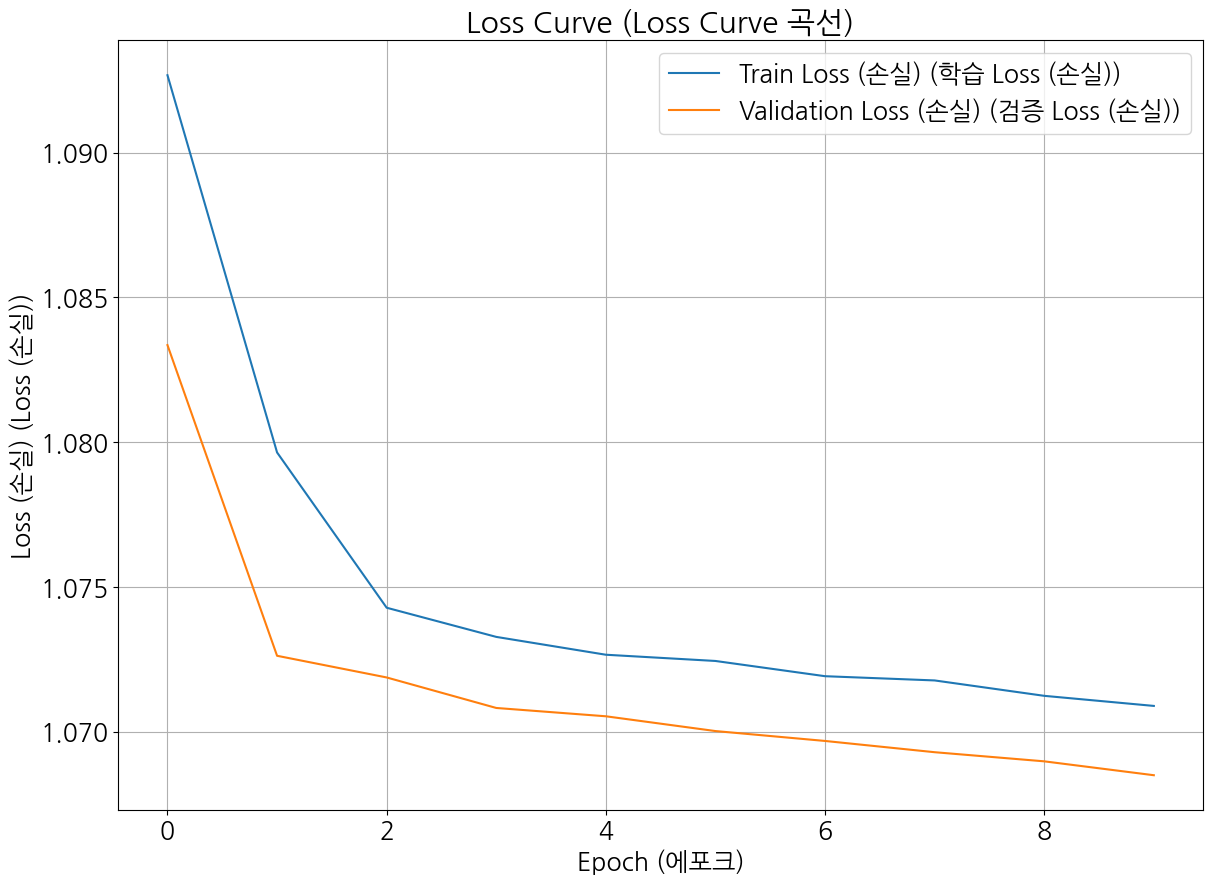

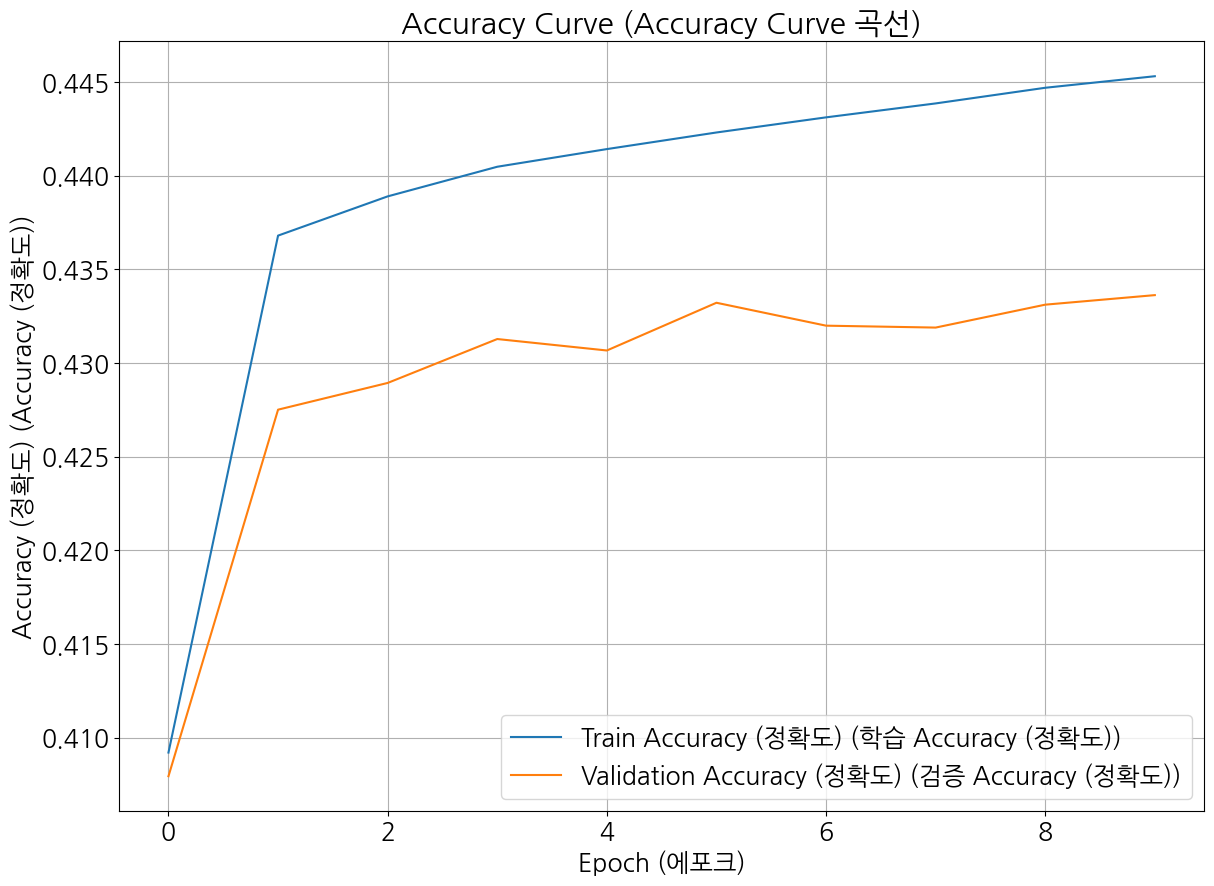

In [103]:
print("[LOG] Training Freeze Pre-trained model...")
model_pretrained = MNLIClassifier(pretrain=True, freeze_encoder=True).to(device)
train_loss_pre_freeze, val_loss_pre_freeze, train_acc_pre_freeze, val_acc_pre_freeze = train(
    model_pretrained, train_loader, test_loader, epochs, lr, save_path, use_amp, min_lr
)


### 10.2. freeze_encoder 미포함

기본값이 True  
for param in model.encoder.parameters():  
    param.requires_grad = True

[LOG] Training Pre-trained model...
[LOG] Epoch 1/10 | Train Loss: 0.6446 | Train Acc: 0.8146 | Val Loss: 0.5216 | Val Acc: 0.7901 | Time: 1391.48s | Learning Rate: 0.000020
[LOG] Epoch 2/10 | Train Loss: 0.4881 | Train Acc: 0.8582 | Val Loss: 0.4880 | Val Acc: 0.8070 | Time: 1391.66s | Learning Rate: 0.000020
[LOG] Epoch 3/10 | Train Loss: 0.3998 | Train Acc: 0.8690 | Val Loss: 0.4919 | Val Acc: 0.8134 | Time: 1390.84s | Learning Rate: 0.000002
[LOG] Epoch 4/10 | Train Loss: 0.3867 | Train Acc: 0.8745 | Val Loss: 0.4946 | Val Acc: 0.8131 | Time: 1393.40s | Learning Rate: 0.000002
[LOG] Epoch 5/10 | Train Loss: 0.3762 | Train Acc: 0.8774 | Val Loss: 0.4956 | Val Acc: 0.8142 | Time: 1394.06s | Learning Rate: 0.000000
[LOG] Epoch 6/10 | Train Loss: 0.3715 | Train Acc: 0.8797 | Val Loss: 0.4970 | Val Acc: 0.8157 | Time: 1395.41s | Learning Rate: 0.000001
[LOG] Epoch 7/10 | Train Loss: 0.3666 | Train Acc: 0.8819 | Val Loss: 0.4989 | Val Acc: 0.8140 | Time: 1397.84s | Learning Rate: 0.00000

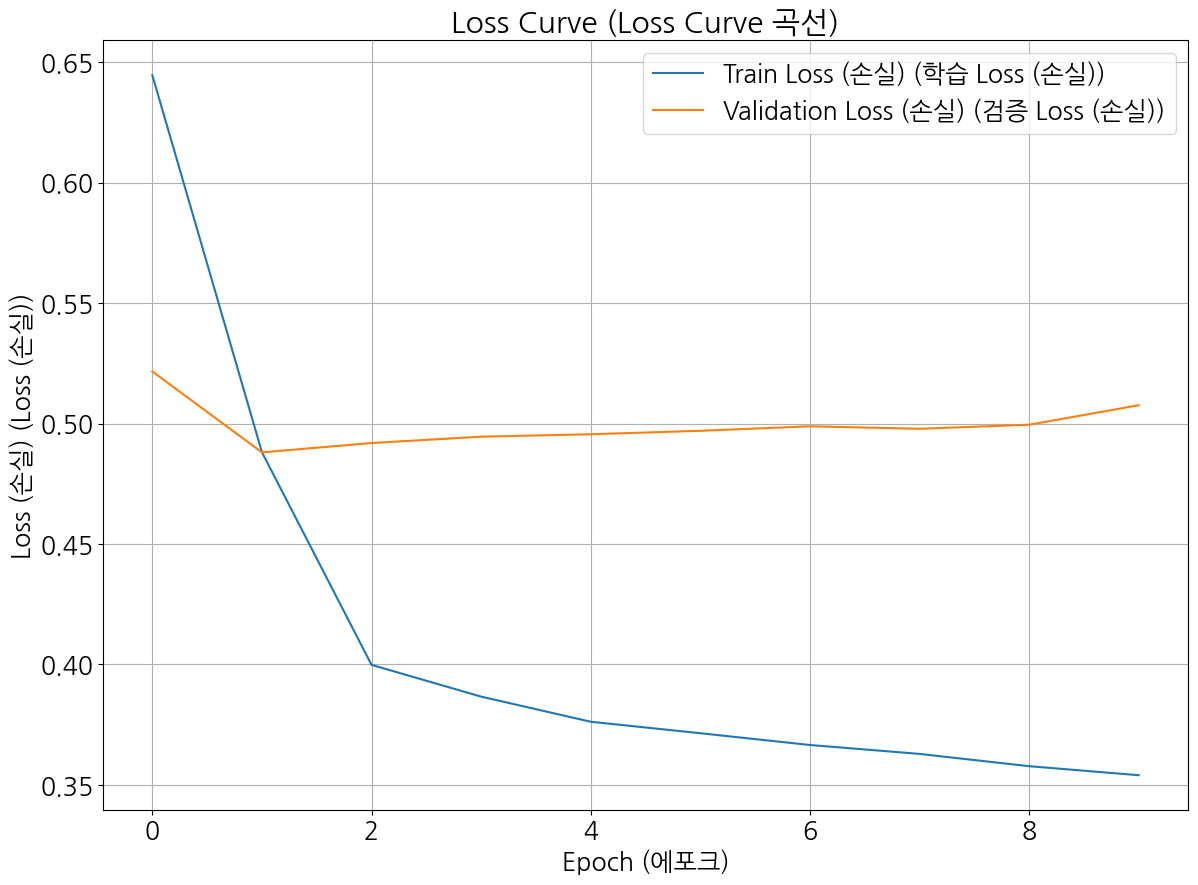

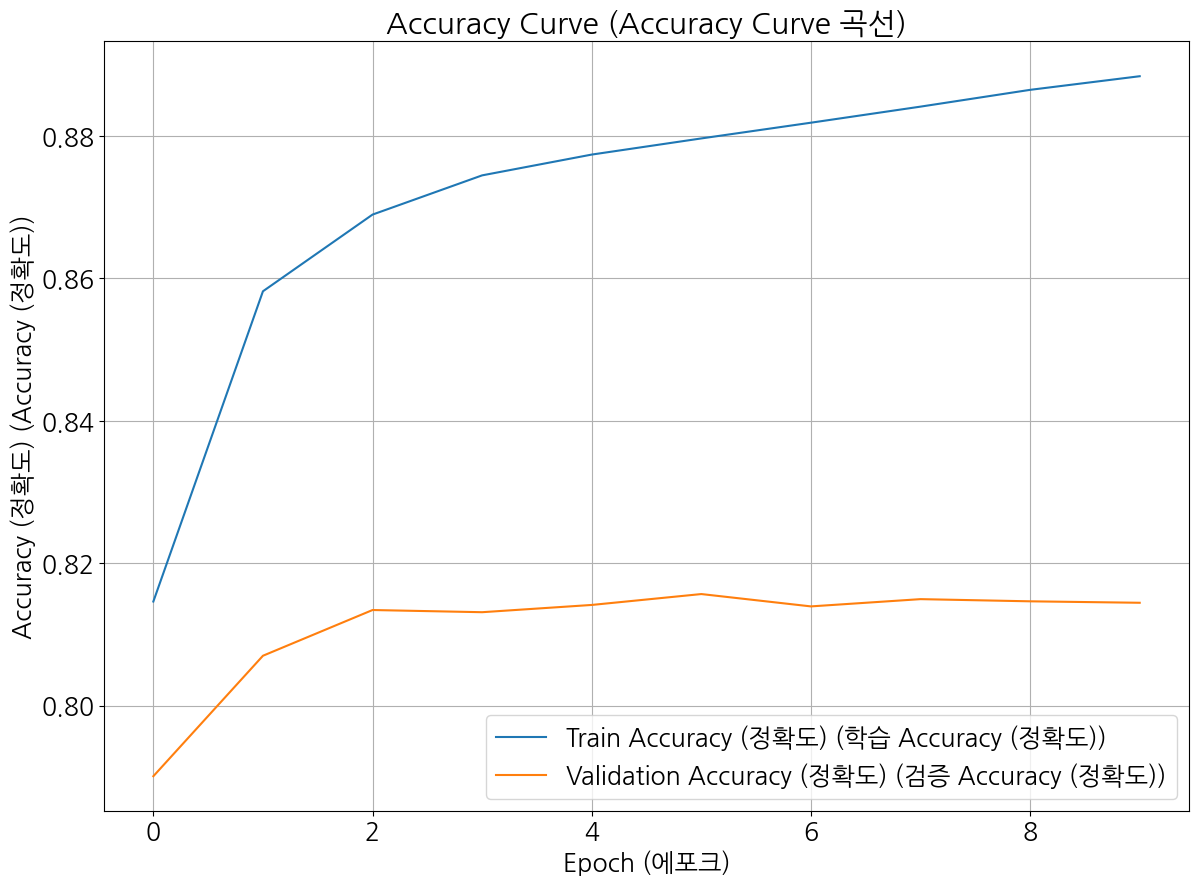

In [104]:
print("[LOG] Training Pre-trained model...")
model_pretrained = MNLIClassifier(pretrain=True, freeze_encoder=False).to(device)
train_loss_pre, val_loss_pre, train_acc_pre, val_acc_pre = train(
    model_pretrained, train_loader, test_loader, epochs, lr, save_path, use_amp, min_lr
)


## 11. Non-pretrained 모델 학습

[LOG] Training Non-pretrained model...
[LOG] Epoch 1/10 | Train Loss: 1.1163 | Train Acc: 0.3405 | Val Loss: 1.0988 | Val Acc: 0.3431 | Time: 1315.28s | Learning Rate: 0.000020
[LOG] Epoch 2/10 | Train Loss: 1.1100 | Train Acc: 0.3516 | Val Loss: 1.0984 | Val Acc: 0.3410 | Time: 1313.37s | Learning Rate: 0.000020
[LOG] Epoch 3/10 | Train Loss: 1.1077 | Train Acc: 0.3522 | Val Loss: 1.0982 | Val Acc: 0.3399 | Time: 1316.75s | Learning Rate: 0.000002
[LOG] Epoch 4/10 | Train Loss: 1.1070 | Train Acc: 0.3531 | Val Loss: 1.0981 | Val Acc: 0.3397 | Time: 1314.80s | Learning Rate: 0.000002
[LOG] Epoch 5/10 | Train Loss: 1.1072 | Train Acc: 0.3536 | Val Loss: 1.0983 | Val Acc: 0.3375 | Time: 1316.46s | Learning Rate: 0.000000
[LOG] Epoch 6/10 | Train Loss: 1.1067 | Train Acc: 0.3538 | Val Loss: 1.0981 | Val Acc: 0.3389 | Time: 1316.33s | Learning Rate: 0.000001
[LOG] Epoch 7/10 | Train Loss: 1.1073 | Train Acc: 0.3544 | Val Loss: 1.0978 | Val Acc: 0.3410 | Time: 1317.28s | Learning Rate: 0.00

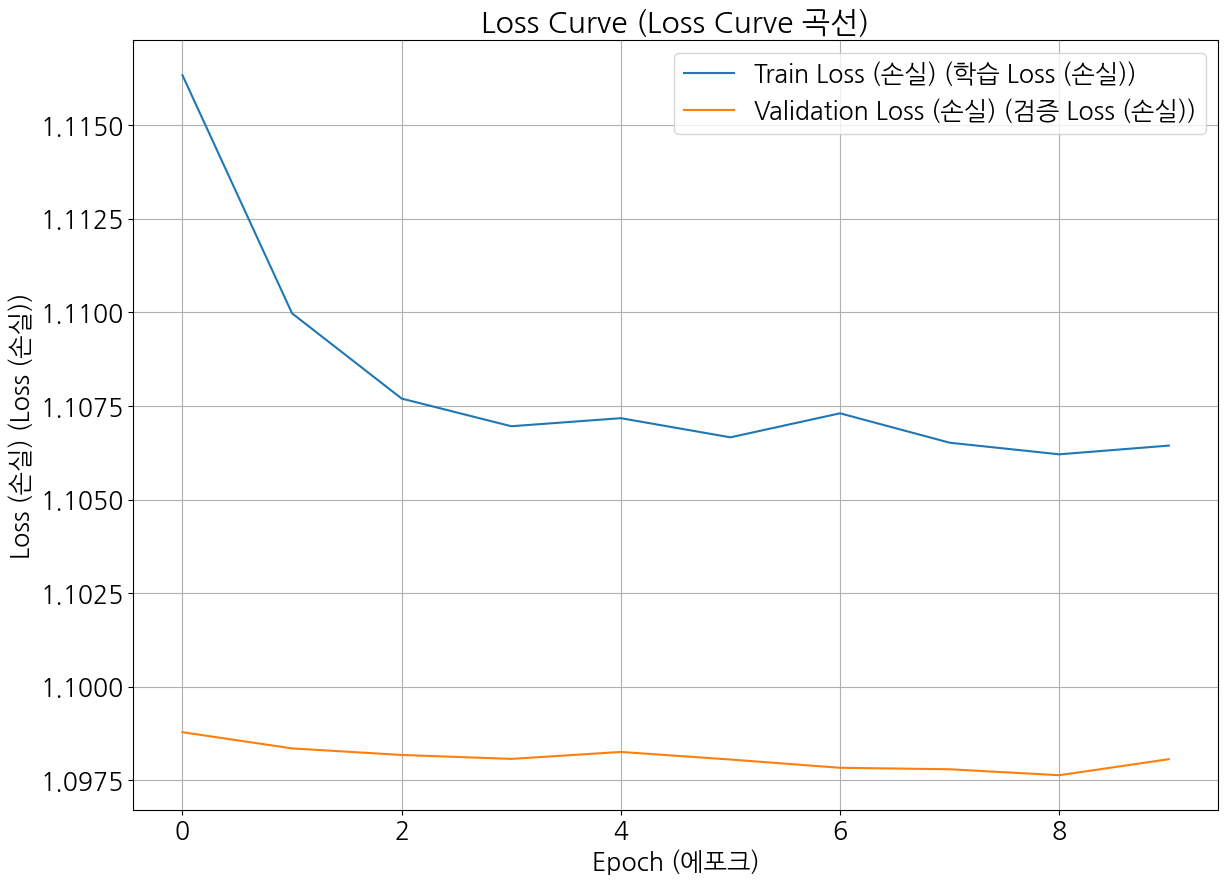

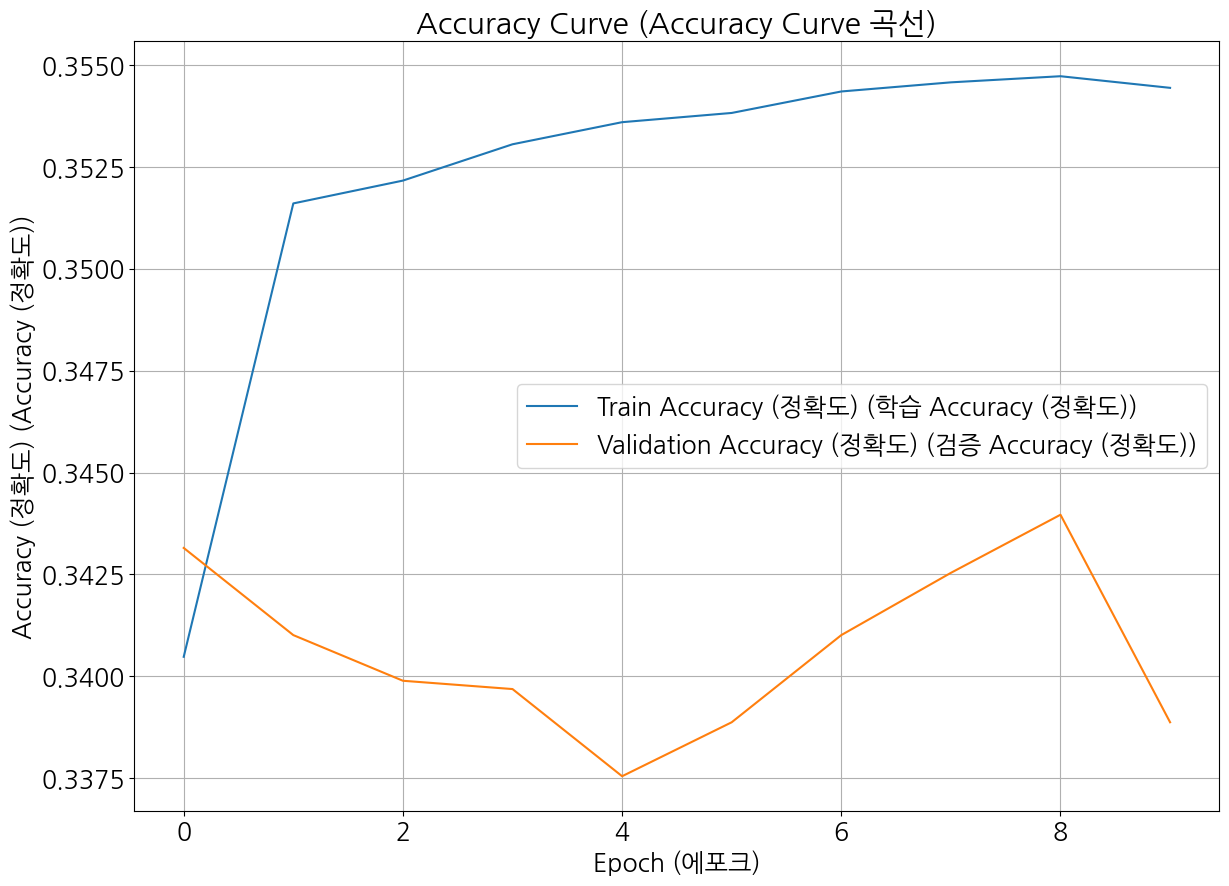

In [105]:
print("[LOG] Training Non-pretrained model...")
model_non_pretrained = MNLIClassifier(pretrain=False, freeze_encoder=True).to(device)
train_loss_non_pre, val_loss_non_pre, train_acc_non_pre, val_acc_non_pre = train(
    model_non_pretrained, train_loader, test_loader, epochs, lr, save_path, use_amp, min_lr
)

## 12. 학습 결과 비교 및 시각화

[LOG] Visualizing and comparing results...


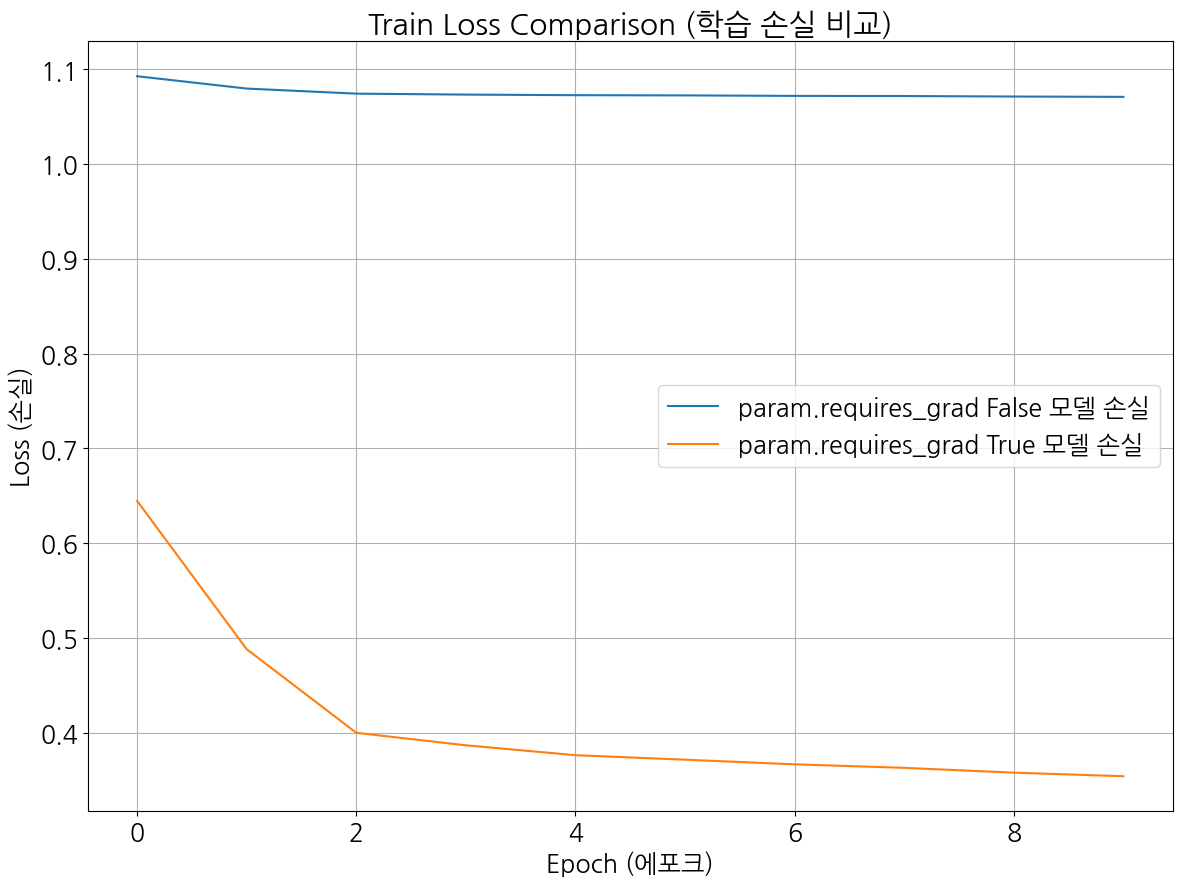

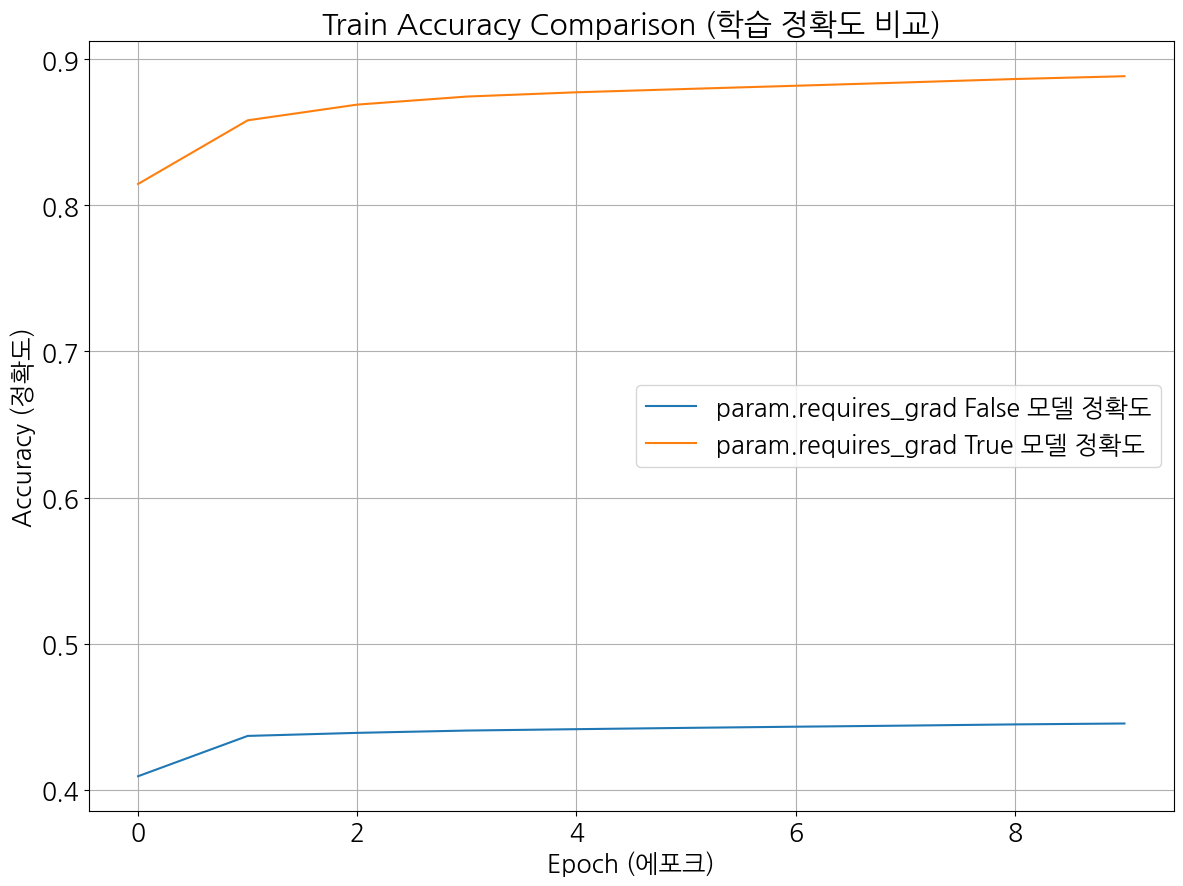




[LOG] Visualizing and comparing results...


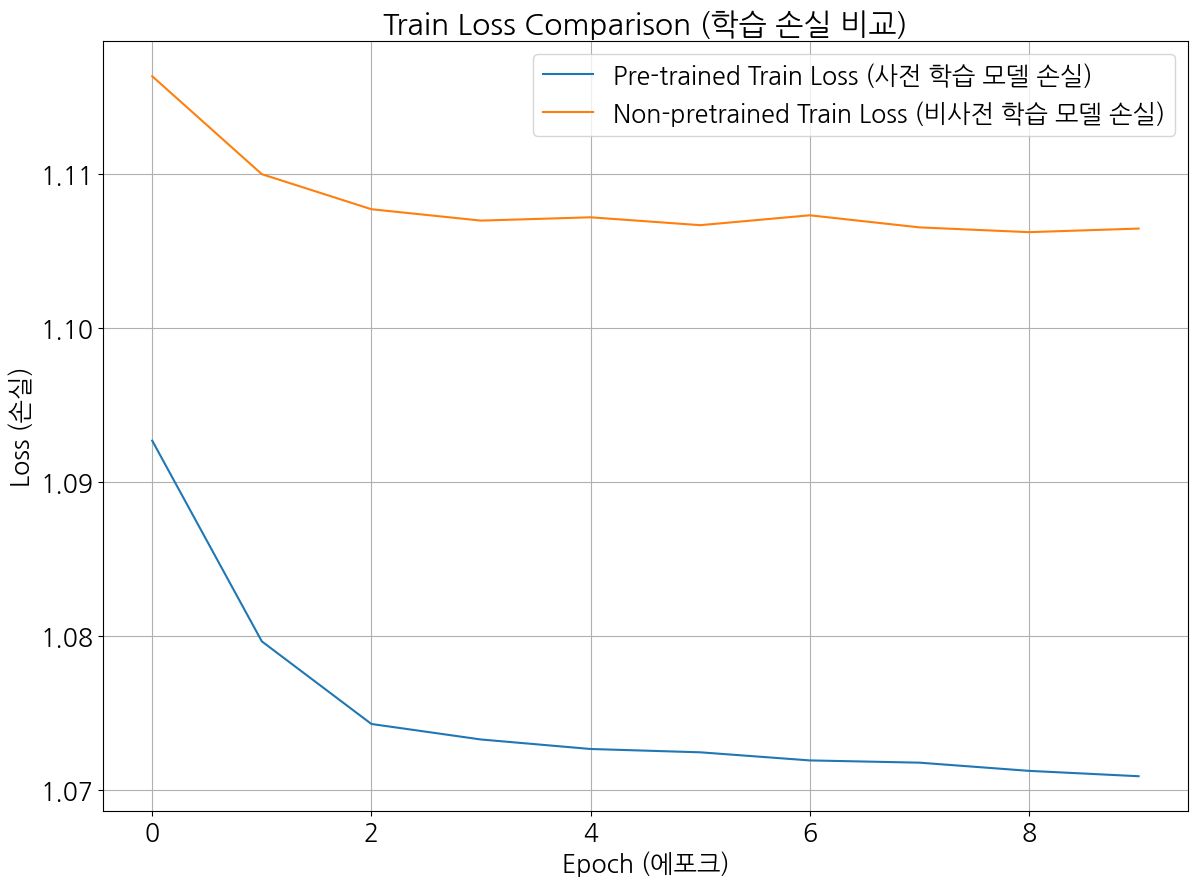

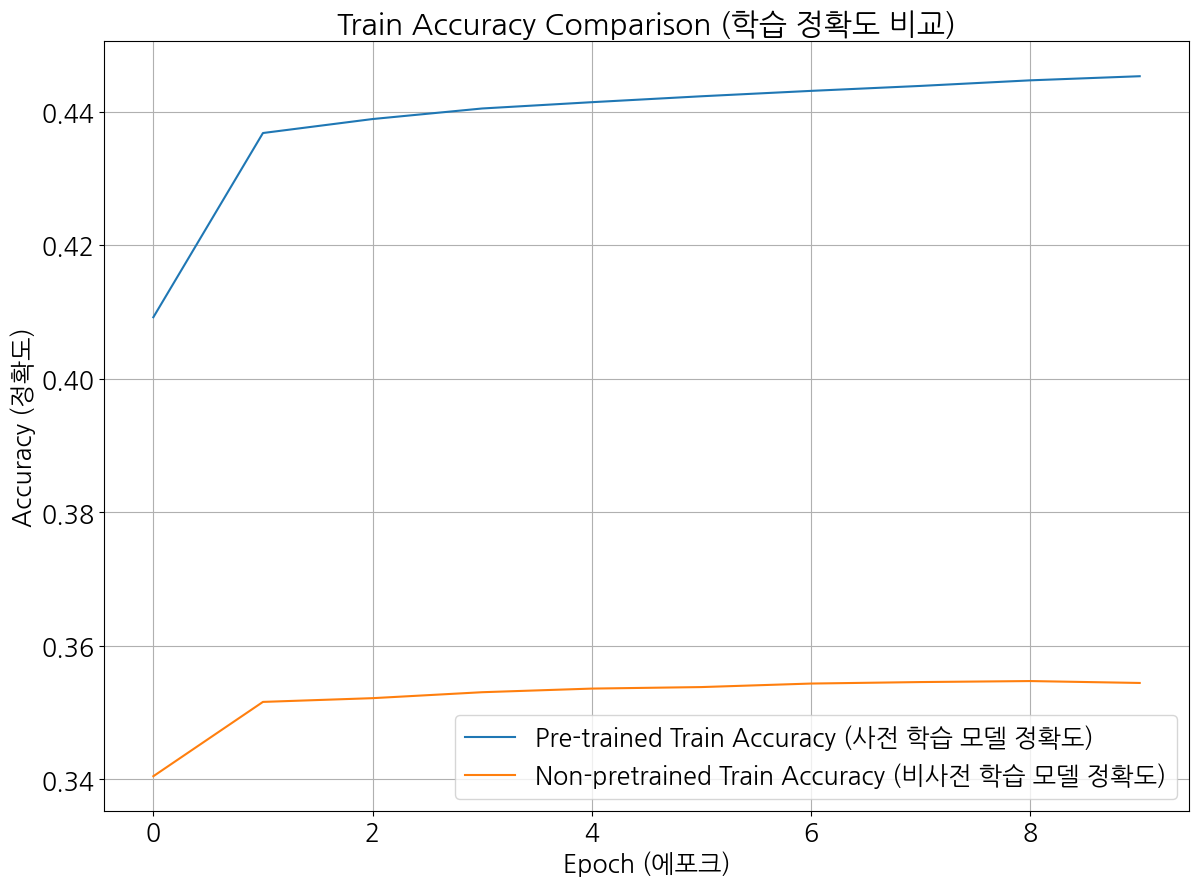

In [106]:
# 학습 결과 비교 및 시각화 호출 (Call to compare and visualize training results)
print("[LOG] Visualizing and comparing results...")
compare_results_freeze(
    train_loss_pre_freeze, train_acc_pre_freeze,  # encoder 레이어 동결
    train_loss_pre, train_acc_pre,  # Pre-trained 모델의 결과
    save_path
)

# 학습 결과 비교 및 시각화 호출 (Call to compare and visualize training results)
print("[LOG] Visualizing and comparing results...")
compare_results(
    train_loss_pre_freeze, train_acc_pre_freeze,  # Pre-trained 모델의 결과 (Pre-trained model results)
    train_loss_non_pre, train_acc_non_pre,  # Non-pretrained 모델의 결과 (Non-pretrained model results)
    save_path
)